# 전이 학습을 통한 키포인트 감지

**Author:** [Sayak Paul](https://twitter.com/RisingSayak)<br>
**Date created:** 2021/05/02<br>
**Last modified:** 2021/05/02<br>
**Description:** 데이터 증대 및 전이 학습을 사용하여 키포인트 탐지기를 훈련합니다.

키포인트 감지는 주요 객체 부분을 찾는 것으로 구성됩니다. 예를 들어, 우리 얼굴의 핵심 부분에는 코끝, 눈썹, 눈꼬리 등이 포함됩니다. 이러한 부분은 기능이 풍부한 방식으로 기본 개체를 나타내는 데 도움이 됩니다. 키포인트 감지에는 포즈 추정, 얼굴 감지 등의 응용 프로그램이 있습니다.

이 예에서는 다음을 사용하여 키포인트 감지기를 빌드합니다.
[StanfordExtra 데이터 세트](https://github.com/benjiebob/StanfordExtra),
전이 학습을 사용합니다. 이 예제에는 TensorFlow 2.4 이상이 필요하고 [`imgaug`](https://imgaug.readthedocs.io/) 라이브러리가 필요합니다.
다음 명령을 사용하여 설치할 수 있습니다.

In [ ]:
!pip install -q -U imgaug

## 데이터 수집

StanfordExtra 데이터 세트에는 12,000개의 개 이미지와 키포인트 및 세분화 맵이 포함되어 있습니다. [Stanford dogs dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/)에서 개발되었습니다.
아래 명령으로 다운로드할 수 있습니다.

In [ ]:
!wget -q http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar

454 / 5,000
번역 결과
주석은 StanfordExtra 데이터 세트에서 단일 JSON 파일로 제공되며 액세스하려면 [이 양식](https://forms.gle/sRtbicgxsWvRtRmUA)을 작성해야 합니다. 그만큼
작성자는 사용자에게 JSON 파일을 공유하지 말라고 명시적으로 지시하며, 이 예는 JSON 파일을 직접 가져와야 합니다.

JSON 파일은 로컬에서 `stanfordextra_v12.zip`으로 사용할 수 있을 것으로 예상됩니다.

파일이 다운로드되면 아카이브를 추출할 수 있습니다. 

In [ ]:
!tar xf images.tar
!unzip -qq ~/stanfordextra_v12.zip

## Imports

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import imgaug.augmenters as iaa

from PIL import Image
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import json
import os

## Define hyperparameters

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 5
NUM_KEYPOINTS = 24 * 2  # 24 pairs each having x and y coordinates

## 데이터 로드

저자는 또한 색상 정보, 동물 포즈 이름 등과 같은 키포인트에 대한 추가 정보를 지정하는 메타데이터 파일을 제공합니다. 이 파일을 'pandas' 데이터 프레임에 로드하여 시각화 목적으로 정보를 추출합니다.

In [ ]:
IMG_DIR = "Images"
JSON = "StanfordExtra_V12/StanfordExtra_v12.json"
KEYPOINT_DEF = (
    "https://github.com/benjiebob/StanfordExtra/raw/master/keypoint_definitions.csv"
)

# Load the ground-truth annotations.
with open(JSON) as infile:
    json_data = json.load(infile)

# Set up a dictionary, mapping all the ground-truth information
# with respect to the path of the image.
json_dict = {i["img_path"]: i for i in json_data}

A single entry of `json_dict` looks like the following:

```
'n02085782-Japanese_spaniel/n02085782_2886.jpg':
{'img_bbox': [205, 20, 116, 201],
 'img_height': 272,
 'img_path': 'n02085782-Japanese_spaniel/n02085782_2886.jpg',
 'img_width': 350,
 'is_multiple_dogs': False,
 'joints': [[108.66666666666667, 252.0, 1],
            [147.66666666666666, 229.0, 1],
            [163.5, 208.5, 1],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [54.0, 244.0, 1],
            [77.33333333333333, 225.33333333333334, 1],
            [79.0, 196.5, 1],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [150.66666666666666, 86.66666666666667, 1],
            [88.66666666666667, 73.0, 1],
            [116.0, 106.33333333333333, 1],
            [109.0, 123.33333333333333, 1],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0]],
 'seg': ...}
```

이 예에서 관심 있는 키는 다음과 같습니다.

* `img_path`
* `관절`

'조인트' 내부에 총 24개의 항목이 있습니다. 각 항목에는 3개의 값이 있습니다.

* x 좌표
* y 좌표
* 키포인트의 가시성 플래그(1은 가시성을 나타내고 0은 비가시성을 나타냄)

우리가 볼 수 있듯이 `joints`에는 다음을 나타내는 여러 `[0, 0, 0]` 항목이 포함되어 있습니다.
키포인트는 레이블이 지정되지 않았습니다. 이 예에서는 보이지 않는 것과 보이지 않는 것을 모두 고려할 것입니다.
미니 배치 학습을 허용하기 위해 레이블이 지정되지 않은 키포인트.

In [ ]:
# Load the metdata definition file and preview it.
keypoint_def = pd.read_csv(KEYPOINT_DEF)
keypoint_def.head()

# Extract the colours and labels.
colours = keypoint_def["Hex colour"].values.tolist()

colours = ["#" + colour for colour in colours]
print(colours)
labels = keypoint_def["Name"].values.tolist()
print(labels)
# Utility for reading an image and for getting its annotations.
def get_dog(name):
    data = json_dict[name]
    img_data = plt.imread(os.path.join(IMG_DIR, data["img_path"]))
    # If the image is RGBA convert it to RGB.
    if img_data.shape[-1] == 4:
        img_data = img_data.astype(np.uint8)
        img_data = Image.fromarray(img_data)
        img_data = np.array(img_data.convert("RGB"))
    data["img_data"] = img_data

    return data


## 데이터 시각화

이제 이미지와 키포인트를 시각화하는 유틸리티 함수를 작성합니다.

In [ ]:
# Parts of this code come from here:
# https://github.com/benjiebob/StanfordExtra/blob/master/demo.ipynb
def visualize_keypoints(images, keypoints):
    fig, axes = plt.subplots(nrows=len(images), ncols=2, figsize=(16, 12))
    [ax.axis("off") for ax in np.ravel(axes)]

    for (ax_orig, ax_all), image, current_keypoint in zip(axes, images, keypoints):
        ax_orig.imshow(image)
        ax_all.imshow(image)

        # If the keypoints were formed by `imgaug` then the coordinates need
        # to be iterated differently.
        if isinstance(current_keypoint, KeypointsOnImage):
            for idx, kp in enumerate(current_keypoint.keypoints):
                ax_all.scatter(
                    [kp.x], [kp.y], c=colours[idx], marker="x", s=50, linewidths=5
                )
        else:
            current_keypoint = np.array(current_keypoint)
            # Since the last entry is the visibility flag, we discard it.
            current_keypoint = current_keypoint[:, :2]
            for idx, (x, y) in enumerate(current_keypoint):
                ax_all.scatter([x], [y], c=colours[idx], marker="x", s=50, linewidths=5)

    plt.tight_layout(pad=2.0)
    plt.show()


# Select four samples randomly for visualization.
samples = list(json_dict.keys())
num_samples = 4
selected_samples = np.random.choice(samples, num_samples, replace=False)

images, keypoints = [], []

for sample in selected_samples:
    data = get_dog(sample)
    image = data["img_data"]
    keypoint = data["joints"]

    images.append(image)
    keypoints.append(keypoint)

visualize_keypoints(images, keypoints)

플롯은 대부분의 실제 시나리오에서 예상되는 균일하지 않은 크기의 이미지가 있음을 보여줍니다. 그러나 이러한 이미지의 크기를 균일한 모양(예: (224 x 224))으로 조정하면 실측 주석도 영향을 받습니다. 이미지에 기하학적 변환(예: 수평 뒤집기)을 적용하는 경우에도 동일하게 적용됩니다.
다행히 'imgaug'는 이 문제를 처리할 수 있는 유틸리티를 제공합니다.
다음 섹션에서는 다음을 상속하는 데이터 생성기를 작성합니다.
[`keras.utils.Sequence`] https://keras.io/api/utils/python_utils/#sequence-class) 클래스
'imgaug'를 사용하여 데이터 배치에 데이터 증대를 적용합니다.

## Prepare data generator

In [61]:

class KeyPointsDataset(keras.utils.Sequence):
    def __init__(self, image_keys, aug, batch_size=BATCH_SIZE, train=True):
        self.image_keys = image_keys
        self.aug = aug
        self.batch_size = batch_size
        self.train = train
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_keys) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_keys))
        if self.train:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        image_keys_temp = [self.image_keys[k] for k in indexes]
        (images, keypoints) = self.__data_generation(image_keys_temp)

        return (images, keypoints)

    def __data_generation(self, image_keys_temp):
        batch_images = np.empty((self.batch_size, IMG_SIZE, IMG_SIZE, 3), dtype="int")
        batch_keypoints = np.empty(
            (self.batch_size, 1, 1, NUM_KEYPOINTS), dtype="float32"
        )

        for i, key in enumerate(image_keys_temp):
            data = get_dog(key)
            current_keypoint = np.array(data["joints"])[:, :2]
            kps = []

            # To apply our data augmentation pipeline, we first need to
            # form Keypoint objects with the original coordinates.
            for j in range(0, len(current_keypoint)):
                kps.append(Keypoint(x=current_keypoint[j][0], y=current_keypoint[j][1]))

            # We then project the original image and its keypoint coordinates.
            current_image = data["img_data"]
            kps_obj = KeypointsOnImage(kps, shape=current_image.shape)

            # Apply the augmentation pipeline.
            (new_image, new_kps_obj) = self.aug(image=current_image, keypoints=kps_obj)
            batch_images[i,] = new_image

            # Parse the coordinates from the new keypoint object.
            kp_temp = []
            for keypoint in new_kps_obj:
                kp_temp.append(np.nan_to_num(keypoint.x))
                kp_temp.append(np.nan_to_num(keypoint.y))

            # More on why this reshaping later.
            batch_keypoints[i,] = np.array(kp_temp).reshape(1, 1, 24 * 2)

        # Scale the coordinates to [0, 1] range.
        batch_keypoints = batch_keypoints / IMG_SIZE

        return (batch_images, batch_keypoints)


'imgaug'에서 키포인트로 작동하는 방법에 대해 자세히 알아보려면 확인하세요.
[this document](https://imgaug.readthedocs.io/en/latest/source/examples_keypoints.html).

C:\Users\jikim\anaconda3\lib\site-packages\imgaug\imgaug.py:2120: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title("imgaug.imshow(%s)" % (image.shape,))


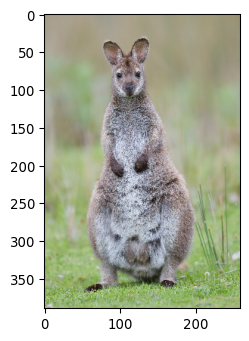

In [52]:
import imageio
import imgaug as ia

image = imageio.imread("https://upload.wikimedia.org/wikipedia/commons/e/e6/Macropus_rufogriseus_rufogriseus_Bruny.jpg")
image = ia.imresize_single_image(image, (389, 259))
ia.imshow(image)

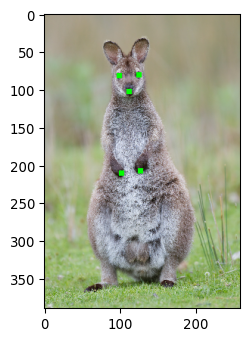

In [56]:
from imgaug.augmentables.kps import Keypoint, KeypointsOnImage
kps = [
    Keypoint(x=99, y=81),   # left eye (from camera perspective)
    Keypoint(x=125, y=80),  # right eye
    Keypoint(x=112, y=102), # nose
    Keypoint(x=102, y=210), # left paw
    Keypoint(x=127, y=207)  # right paw
]
kpsoi = KeypointsOnImage(kps, shape=image.shape)

ia.imshow(kpsoi.draw_on_image(image, size=7))

KeypointsOnImage([Keypoint(x=99.00000000, y=81.00000000), Keypoint(x=125.00000000, y=80.00000000), Keypoint(x=112.00000000, y=102.00000000), Keypoint(x=102.00000000, y=210.00000000), Keypoint(x=127.00000000, y=207.00000000)], shape=(389, 259, 3))
KeypointsOnImage([Keypoint(x=108.93547821, y=86.16545105), Keypoint(x=134.56158447, y=81.65958405), Keypoint(x=124.65520477, y=105.21512604), Keypoint(x=129.34797668, y=213.57553101), Keypoint(x=153.71287537, y=207.22322083)], shape=(389, 259, 3))


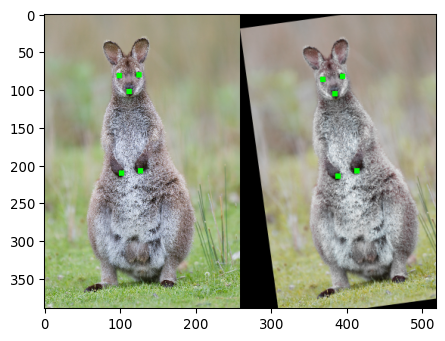

In [58]:
import imgaug.augmenters as iaa
ia.seed(3)

seq = iaa.Sequential([
    iaa.Affine(translate_px={"x": (10, 30)}, rotate=(-10, 10)),
    iaa.AddToHueAndSaturation((-50, 50))  # color jitter, only affects the image
])

image_aug, kpsoi_aug = seq(image=image, keypoints=kpsoi)
print(kpsoi)
print(kpsoi_aug)
ia.imshow(
    np.hstack([
        kpsoi.draw_on_image(image, size=7),
        kpsoi_aug.draw_on_image(image_aug, size=7)
    ])
)

## 증대 변환 정의

In [62]:
train_aug = iaa.Sequential(
    [
        iaa.Resize(IMG_SIZE, interpolation="linear"),
        iaa.Fliplr(0.3),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        iaa.Sometimes(0.3, iaa.Affine(rotate=10, scale=(0.5, 0.7))),
    ]
)

test_aug = iaa.Sequential([iaa.Resize(IMG_SIZE, interpolation="linear")])

## 훈련 및 검증 분할 생성

In [63]:
np.random.shuffle(samples)
train_keys, validation_keys = (
    samples[int(len(samples) * 0.15) :],
    samples[: int(len(samples) * 0.15)],
)


## 데이터 생성기 조사

Total batches in training set: 166
Total batches in validation set: 29


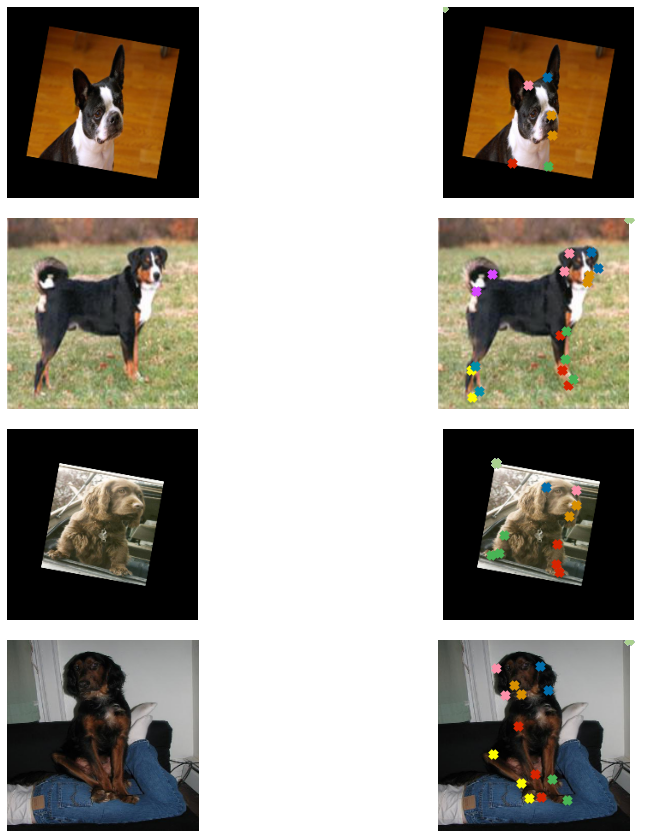

In [64]:
train_dataset = KeyPointsDataset(train_keys, train_aug)
validation_dataset = KeyPointsDataset(validation_keys, test_aug, train=False)

print(f"Total batches in training set: {len(train_dataset)}")
print(f"Total batches in validation set: {len(validation_dataset)}")

sample_images, sample_keypoints = next(iter(train_dataset))
assert sample_keypoints.max() == 1.0
assert sample_keypoints.min() == 0.0

sample_keypoints = sample_keypoints[:4].reshape(-1, 24, 2) * IMG_SIZE
visualize_keypoints(sample_images[:4], sample_keypoints)

## Model building

이 [Stanford dogs dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/) (StanfordExtra 데이터셋의 기반이 되는) 를 사용하여 빌드되었습니다. [ImageNet-1k dataset](http://image-net.org/).
따라서 ImageNet-1k 데이터 세트에서 사전 훈련된 모델이 이 작업에 유용할 수 있습니다. 이 데이터 세트에 대해 사전 훈련된 MobileNetV2를 백본으로 사용하여 이미지에서 의미 있는 기능을 추출한 다음 좌표를 예측하기 위해 사용자 정의 회귀 헤드로 전달합니다.

In [65]:

def get_model():
    # Load the pre-trained weights of MobileNetV2 and freeze the weights
    backbone = keras.applications.MobileNetV2(
        weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    backbone.trainable = False

    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    x = keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = backbone(x)
    x = layers.Dropout(0.3)(x)
    x = layers.SeparableConv2D(
        NUM_KEYPOINTS, kernel_size=5, strides=1, activation="relu"
    )(x)
    outputs = layers.SeparableConv2D(
        NUM_KEYPOINTS, kernel_size=3, strides=1, activation="sigmoid"
    )(x)

    return keras.Model(inputs, outputs, name="keypoint_detector")


우리의 커스텀 네트워크는 완전히 연결된 조밀한 레이어를 가진 동일한 버전의 네트워크보다 매개변수 친화적인 완전 컨볼루션입니다.

In [66]:
get_model().summary()

Model: "keypoint_detector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 dropout_2 (Dropout)         (None, 7, 7, 1280)        0         
                                                 

네트워크의 출력 모양을 확인하십시오.: `(None, 1, 1, 48)`. 
<br>이것이 좌표를 다음과 같이 재구성한 이유입니다.: `batch_keypoints[i, :] = np.array(kp_temp).reshape(1, 1, 24 * 2)`.

## 모델 컴파일 및 훈련

이 예에서 우리는 5개의 Epoch 동안만 네트워크를 훈련할 것입니다.

In [ ]:
model = get_model()
model.compile(loss="mse", optimizer=keras.optimizers.Adam(1e-4))
model.fit(train_dataset, validation_data=validation_dataset, epochs=EPOCHS)

Epoch 1/5
166/166 [==============================] - 166s 990ms/step - loss: 0.1031 - val_loss: 0.0921
Epoch 2/5
111/166 [===================>..........] - ETA: 47s - loss: 0.0816

## 예측하고 시각화

In [ ]:
sample_val_images, sample_val_keypoints = next(iter(validation_dataset))
sample_val_images = sample_val_images[:4]
sample_val_keypoints = sample_val_keypoints[:4].reshape(-1, 24, 2) * IMG_SIZE
predictions = model.predict(sample_val_images).reshape(-1, 24, 2) * IMG_SIZE

# Ground-truth
visualize_keypoints(sample_val_images, sample_val_keypoints)

# Predictions
visualize_keypoints(sample_val_images, predictions)

더 많은 훈련을 통해 예측이 향상될 것입니다.